# ***IMPORTING LIBRARIES***

In [19]:
%%time

import os, random
import numpy as np
import pandas as pd
import imghdr
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization,Conv2D, MaxPooling2D
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3, ResNet101
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Importing warnings
import warnings
warnings.filterwarnings('ignore')

CPU times: total: 0 ns
Wall time: 0 ns


# **REMOVING FILES OTHER THAN IMAGES**

In [22]:
%%time

image_types= ['jpeg','png', 'jpg']
for root, dirs, files in os.walk('C:/Users/Lenovo/CLDD/thesis Code/Cotton'):
    for file in files:
        file_path = os.path.join(root, file)
        image_type = imghdr.what(file_path)
        if image_type not in image_types:
            print('File name : '.format(file, image_type))
        else:
            cv2.imread(file_path)

File name : 
CPU times: total: 9.59 s
Wall time: 9.64 s


# **CHECKING IMAGES OF 4 CLASSES**

CPU times: total: 172 ms
Wall time: 170 ms


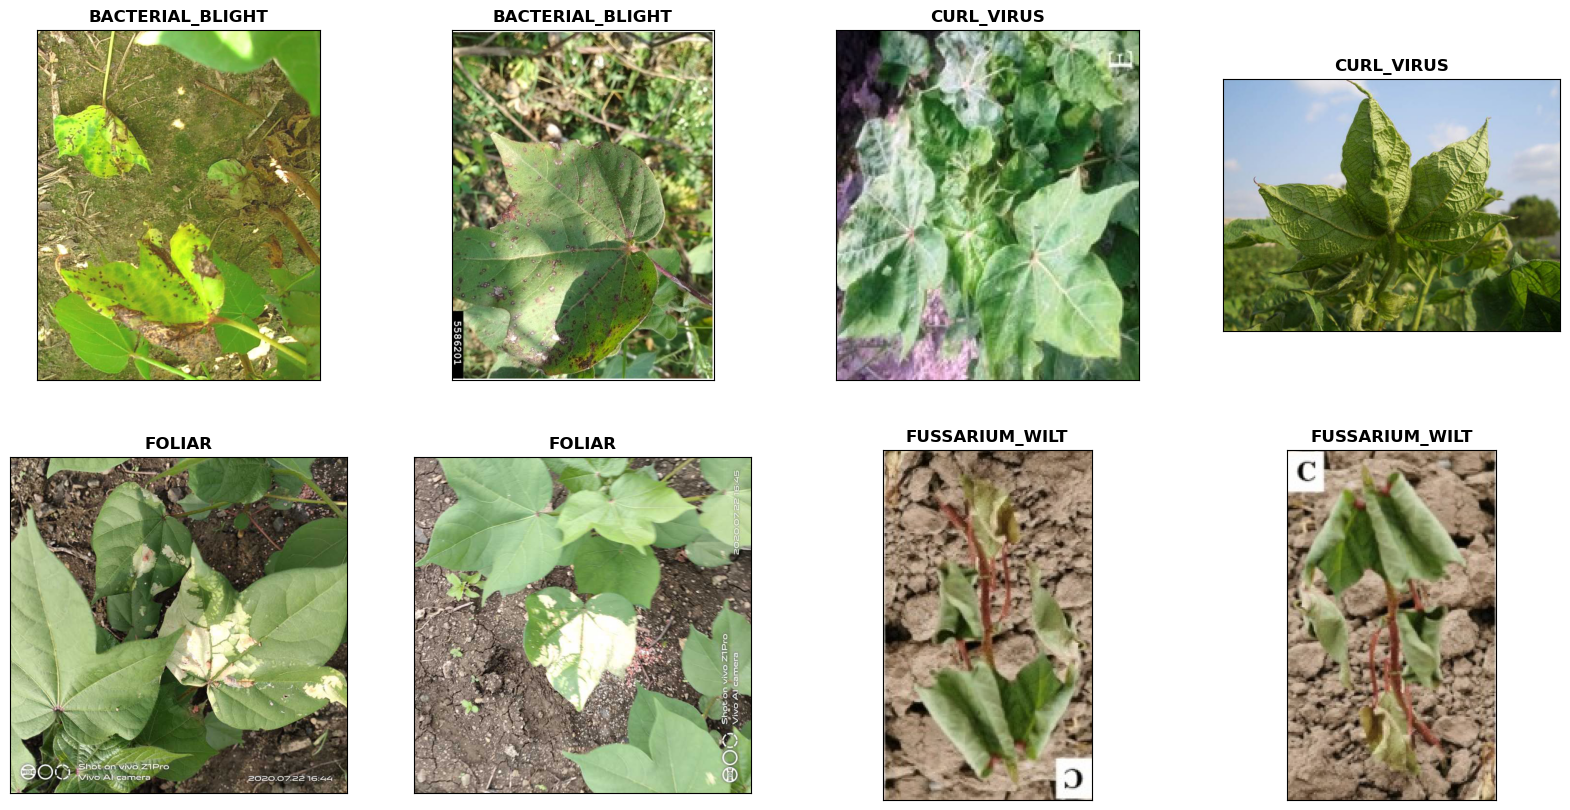

In [27]:
%%time
fig, axes = plt.subplots(2,4, figsize=(20,10))
ax = axes.ravel()
i=0
path = 'C:/Users/Lenovo/CLDD/thesis Code/Cotton/train'
for folder in os.listdir(path):
    folder_path = os.path.join(path, folder)
    image = os.listdir(folder_path)
    selected_img = random.sample(image,2)

    for image in selected_img:
        if i >= len(ax):  # Prevent IndexError
            break
        img_path = os.path.join(folder_path, image)
        img = plt.imread(img_path)
        ax[i].set_title(folder.upper(),fontweight='bold')
        ax[i].imshow(img)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        i=i+1

# **QUANTITY OF IMAGES IN EACH TRAIN DIRECTORY**

Number of Images in bacterial_blight: 434
Number of Images in curl_virus: 334
Number of Images in foliar: 108
Number of Images in fussarium_wilt: 335
Number of Images in healthy: 340


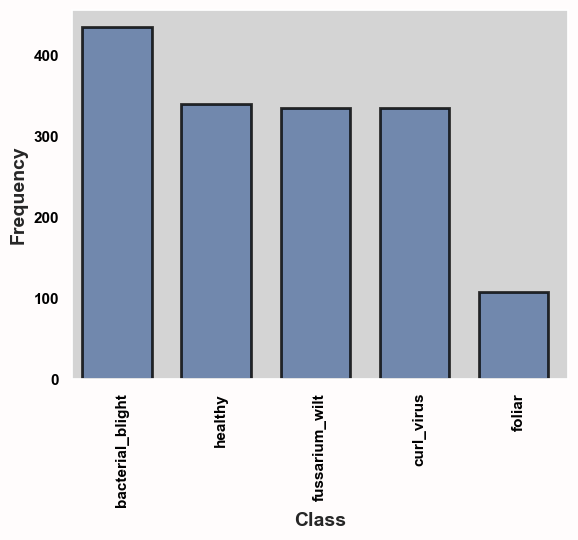

CPU times: total: 219 ms
Wall time: 233 ms


In [29]:
%%time

sns.set(rc={'axes.facecolor': '#d4d4d4', 'figure.facecolor': '#fffcfc'})

# Function to count images in each folder
def images_count(path, name):
    count = {}
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            count[folder] = len(os.listdir(folder_path))
            print(f'\033[1mNumber of Images in {folder}: {count[folder]}\033[0m')
    # Create DataFrame and prepare it for plotting
    df = pd.DataFrame(count, index=[name]).melt(var_name='class').sort_values(by='value', ascending=False)
    return df

# Get the image count DataFrame
class_count = images_count('C:/Users/Lenovo/CLDD/thesis Code/Cotton/train', 'train')

# Plot the barplot
ax = sns.barplot(data=class_count, x='class', y='value', edgecolor='black', linewidth=2, alpha=0.8)

# Manually adjust the width of the bars
for bar in ax.patches:
    bar.set_width(0.7)

# Customize the axes labels and ticks
plt.xticks(rotation=90, color='black', weight='bold')
plt.yticks(color='black', weight='bold')
plt.xlabel('Class', weight='bold', fontsize=14)
plt.ylabel('Frequency', weight='bold', fontsize=14)

# Disable grid lines
plt.grid(False)

# Display the plot
plt.show()

# **DATA AUGMENTATION**

In [32]:
%%time

train_gen = ImageDataGenerator(rescale=1./255, rotation_range=20, shear_range=0.2,zoom_range=0.5,
                                fill_mode='nearest', horizontal_flip=True, width_shift_range=0.2)
train_generator = train_gen.flow_from_directory('C:/Users/Lenovo/CLDD/thesis Code/Cotton/train', target_size=(224,224), batch_size=32,
                                              color_mode='rgb', class_mode='categorical')

Found 1550 images belonging to 5 classes.
CPU times: total: 125 ms
Wall time: 134 ms


In [35]:
# Total no of samples in training set
train_generator.classes.shape

# Computing class weights using scikit-learn library's function compute_class_weight
classes = train_generator.classes    # Array of original class labels per sample
weights = compute_class_weight(class_weight='balanced', classes=np.unique(classes),y=classes)

# Weights Dictionary
weight_dict = dict(enumerate(weights))
weight_dict

{0: 0.7142857142857143,
 1: 0.9309309309309309,
 2: 2.8703703703703702,
 3: 0.9253731343283582,
 4: 0.9117647058823529}

In [37]:
%%time

val_gen = ImageDataGenerator(rescale=1./255)

validation_generator = val_gen.flow_from_directory('C:/Users/Lenovo/CLDD/thesis Code/Cotton/val', target_size=(224,224), batch_size=32,
                                              color_mode='rgb', class_mode='categorical')

test_generator =  val_gen.flow_from_directory('C:/Users/Lenovo/CLDD/thesis Code/Cotton/test', target_size=(224,224), batch_size=32,
                                              color_mode='rgb', class_mode='categorical')

Found 369 images belonging to 5 classes.
Found 403 images belonging to 5 classes.
CPU times: total: 109 ms
Wall time: 105 ms


# **RESNET_50 & 101 & 152V2

In [40]:
%%time

#resnet = ResNet152V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#resnet = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

CPU times: total: 2.7 s
Wall time: 2.31 s


In [41]:
# define the model architecture
#model = tf.keras.models.Sequential()
#model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
#model.add(MaxPooling2D((2, 2)))
#model.add(Conv2D(64, (3, 3), activation='relu'))
#model.add(MaxPooling2D((2, 2)))
#model.add(Conv2D(128, (3, 3), activation='relu'))
#model.add(MaxPooling2D((2, 2)))
#model.add(Flatten())
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(4, activation='softmax'))

# compile the model
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train the model
#history = model.fit(train_generator, epochs=10, validation_data=test_generator)

# **TRAINING RESNET50 MODEL**

In [52]:
%%time

# Freezing base model
for layer in resnet.layers:
    layer.trainable = False

# Adding custom layers on top of model
x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

# Predictions
predictions = Dense(5, activation='softmax')(x)

# Building Model
model = Model(inputs=resnet.input, outputs=predictions)

CPU times: total: 141 ms
Wall time: 145 ms


# **COMPILING RESNET50 MODEL**

In [60]:
%%time

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#callbacks = EarlyStopping(monitor='val_accuracy', verbose=1, #patience=3,
#                            mode='max', restore_best_weights=True)

CPU times: total: 31.2 ms
Wall time: 17 ms


# **FITTING RESNET50 MODEL**

In [63]:
history = model.fit(train_generator, validation_data=validation_generator, epochs=10, verbose=1, class_weight=weight_dict)#callbacks=[callbacks]

Epoch 1/10
49/49 [==============================] - 145s 3s/step - loss: 1.7629 - accuracy: 0.3619 - val_loss: 1.6319 - val_accuracy: 0.3008
Epoch 2/10
49/49 [==============================] - 141s 3s/step - loss: 1.5859 - accuracy: 0.3832 - val_loss: 1.5134 - val_accuracy: 0.3008
Epoch 3/10
49/49 [==============================] - 142s 3s/step - loss: 1.4603 - accuracy: 0.4194 - val_loss: 1.4478 - val_accuracy: 0.3171
Epoch 4/10
49/49 [==============================] - 143s 3s/step - loss: 1.3649 - accuracy: 0.4219 - val_loss: 1.4187 - val_accuracy: 0.3496
Epoch 5/10
49/49 [==============================] - 142s 3s/step - loss: 1.3303 - accuracy: 0.4439 - val_loss: 1.3535 - val_accuracy: 0.4119
Epoch 6/10
49/49 [==============================] - 141s 3s/step - loss: 1.3047 - accuracy: 0.4574 - val_loss: 1.3259 - val_accuracy: 0.4743
Epoch 7/10
49/49 [==============================] - 145s 3s/step - loss: 1.3151 - accuracy: 0.4587 - val_loss: 1.2935 - val_accuracy: 0.5095
Epoch 8/10
49

# Save Resnet Model

In [165]:
#latest saved method using keras extention
#model.save('Cotton_leaf_disease_Resnet.keras')
model.save('C:/Users/Lenovo/CLDD/thesis Code/Model/Cotton_leaf_disease_Resnet101.keras')

# **EVALUATING RESNET50 MODEL**

In [65]:
# Evaluate on the validation set
val_loss, val_acc = model.evaluate(validation_generator)
print(f'\033[1mValidation Accuracy: {val_acc * 100:.2f}%\033[0m')

# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'\033[1mTest Accuracy: {test_acc * 100:.2f}%\033[0m')

12/12 [==============================] - 22s 2s/step - loss: 1.1627 - accuracy: 0.5691
Validation Accuracy: 56.91%
13/13 [==============================] - 28s 2s/step - loss: 1.2037 - accuracy: 0.5658
Test Accuracy: 56.58%


# **RESNET50 MODEL PREDICTIONS**

In [67]:
# Make predictions on the test set
predictions = model.predict(test_generator)

# Convert predictions to class labels
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Print the predictions
print("Predicted labels:", y_pred)
print("True labels:", y_true)
print("Class labels:", class_labels)



13/13 [==============================] - 26s 2s/step
Predicted labels: [2 0 2 0 2 0 1 4 0 2 3 2 3 0 0 4 0 0 4 4 0 0 1 0 4 3 3 0 1 3 2 2 0 4 4 0 1
 3 3 2 2 3 3 4 2 0 0 0 0 0 4 4 0 4 4 4 0 2 2 1 0 0 4 1 0 1 0 1 2 0 1 3 4 3
 3 0 2 3 1 2 0 4 3 3 1 0 1 4 4 3 3 2 3 2 0 4 3 3 3 3 1 0 0 0 0 3 2 0 0 2 2
 2 0 0 4 0 3 4 2 0 2 4 0 2 3 1 2 4 3 2 1 2 2 2 0 2 2 2 0 3 2 2 1 0 2 0 3 0
 3 0 1 0 0 4 1 3 3 2 3 2 2 0 2 2 0 0 2 1 4 2 2 0 3 0 1 4 0 0 3 0 0 3 2 0 1
 3 4 2 0 0 4 1 0 2 0 3 0 0 2 1 3 4 2 0 0 2 4 2 4 1 3 1 2 2 1 0 0 0 3 3 2 3
 2 1 2 2 4 4 2 2 3 2 2 3 3 4 4 4 1 0 0 0 3 3 3 2 0 4 3 2 2 0 0 0 4 2 3 1 1
 0 3 1 0 4 2 0 3 3 1 0 2 0 0 4 2 2 4 3 1 4 3 3 2 0 0 0 0 2 0 3 0 0 4 2 0 3
 2 0 1 2 3 0 0 4 0 0 0 0 0 0 3 3 4 4 2 0 4 0 3 0 0 0 3 3 3 2 2 2 0 0 3 0 2
 2 0 2 3 2 1 0 2 1 3 2 0 4 0 1 3 2 2 0 3 0 0 2 0 0 3 0 2 2 0 0 0 2 4 2 1 2
 2 4 2 3 2 0 3 3 2 0 1 4 2 0 0 0 2 3 2 2 1 1 0 2 4 0 1 0 0 0 4 4 2]
True labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 

In [69]:
if len(y_pred) == 0:
    print("No predictions were made.")
else:
    # Iterate over each prediction
    for i in range(len(y_pred)):
        if y_pred[i] == 0:
            preds = "The leaf is bacterial blight"
        elif y_pred[i] == 1:
            preds = "The leaf is curl virus"
        elif y_pred[i] == 2:
            preds = "The leaf is fussarium wilt"
        else:
            preds = "The leaf is healthy"

        print(f"Prediction {i+1}: {preds}")

Prediction 1: The leaf is fussarium wilt
Prediction 2: The leaf is bacterial blight
Prediction 3: The leaf is fussarium wilt
Prediction 4: The leaf is bacterial blight
Prediction 5: The leaf is fussarium wilt
Prediction 6: The leaf is bacterial blight
Prediction 7: The leaf is curl virus
Prediction 8: The leaf is healthy
Prediction 9: The leaf is bacterial blight
Prediction 10: The leaf is fussarium wilt
Prediction 11: The leaf is healthy
Prediction 12: The leaf is fussarium wilt
Prediction 13: The leaf is healthy
Prediction 14: The leaf is bacterial blight
Prediction 15: The leaf is bacterial blight
Prediction 16: The leaf is healthy
Prediction 17: The leaf is bacterial blight
Prediction 18: The leaf is bacterial blight
Prediction 19: The leaf is healthy
Prediction 20: The leaf is healthy
Prediction 21: The leaf is bacterial blight
Prediction 22: The leaf is bacterial blight
Prediction 23: The leaf is curl virus
Prediction 24: The leaf is bacterial blight
Prediction 25: The leaf is he

# **RESNET50 CLASSIFICATION REPORT**

In [71]:
report = classification_report(y_true,y_pred,target_names=class_labels)
print(report)

                  precision    recall  f1-score   support

bacterial_blight       0.22      0.32      0.26        90
      curl_virus       0.17      0.08      0.11        84
          foliar       0.17      0.28      0.21        60
  fussarium_wilt       0.23      0.20      0.21        84
         healthy       0.13      0.08      0.10        85

        accuracy                           0.19       403
       macro avg       0.18      0.19      0.18       403
    weighted avg       0.18      0.19      0.18       403



# **PLOTTING RESNET50 LOSS AND ACCURACY**

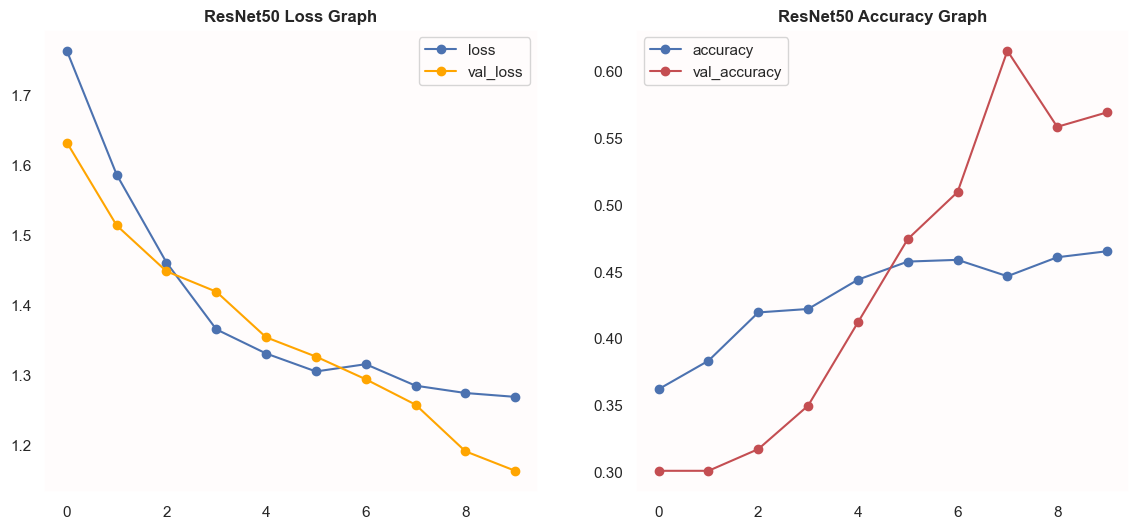

In [73]:
sns.set_theme(rc={'axes.facecolor':'#fffcfc','figure.facecolor':'#ffffff'})

fig,ax = plt.subplots(1,2,figsize=(14,6))

ax[0].plot(history.history['loss'],label='loss', marker='o', color='b')
ax[0].plot(history.history['val_loss'],label='val_loss', marker='o', color='orange')
ax[0].set_title('ResNet50 Loss Graph',fontweight='bold')
ax[0].legend()
ax[0].grid(False)

ax[1].plot(history.history['accuracy'],label='accuracy',marker='o', color='b')
ax[1].plot(history.history['val_accuracy'],label='val_accuracy',marker='o', color='r')
ax[1].set_title('ResNet50 Accuracy Graph',fontweight='bold')
ax[1].legend()
ax[1].grid(False)

plt.show()

# **VGG_16**

In [75]:
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# **TRAINING VGG166 MODEL**

In [83]:
%%time

# Freezing base model
for layer in vgg16.layers:
    layer.trainable = False

# Adding custom layers on top of model
x = vgg16.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

# Predictions
predictions1 = Dense(5, activation='softmax')(x)

# Building Model
model1 = Model(inputs=vgg16.input, outputs=predictions1)

CPU times: total: 125 ms
Wall time: 116 ms


# **COMPILING VGG16 MODEL**

In [85]:
%%time

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
callbacks = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1,
                            mode='max', restore_best_weights=True)

CPU times: total: 15.6 ms
Wall time: 8.98 ms


# **FITTING VGG16 MODEL**

In [87]:
history1 = model1.fit(train_generator, validation_data=validation_generator, epochs=10, callbacks=[callbacks], verbose=1, class_weight=weight_dict)

Epoch 1/10
49/49 [==============================] - 442s 9s/step - loss: 1.1174 - accuracy: 0.6129 - val_loss: 1.1611 - val_accuracy: 0.6179
Epoch 2/10
49/49 [==============================] - 439s 9s/step - loss: 0.6778 - accuracy: 0.7465 - val_loss: 0.9533 - val_accuracy: 0.6775
Epoch 3/10
49/49 [==============================] - 446s 9s/step - loss: 0.6136 - accuracy: 0.7806 - val_loss: 0.6760 - val_accuracy: 0.8076
Epoch 4/10
49/49 [==============================] - 440s 9s/step - loss: 0.5241 - accuracy: 0.8052 - val_loss: 0.5246 - val_accuracy: 0.8645
Epoch 5/10
49/49 [==============================] - 436s 9s/step - loss: 0.5150 - accuracy: 0.8097 - val_loss: 0.4418 - val_accuracy: 0.8455
Epoch 6/10
49/49 [==============================] - 439s 9s/step - loss: 0.5219 - accuracy: 0.8032 - val_loss: 0.3139 - val_accuracy: 0.9187
Epoch 7/10
49/49 [==============================] - 436s 9s/step - loss: 0.4379 - accuracy: 0.8297 - val_loss: 0.2647 - val_accuracy: 0.9268
Epoch 8/10
49

# **EVALUATING VGG16 MODEL**

In [89]:
# Evaluate on the validation set
val_loss, val_acc = model1.evaluate(validation_generator)
print(f'\033[1mValidation Accuracy: {val_acc * 100:.2f}%\033[0m')

# Evaluate on the test set
test_loss, test_acc = model1.evaluate(test_generator)
print(f'\033[1mTest Accuracy: {test_acc * 100:.2f}%\033[0m')

12/12 [==============================] - 82s 7s/step - loss: 0.1365 - accuracy: 0.9621
Validation Accuracy: 96.21%
13/13 [==============================] - 95s 7s/step - loss: 0.2250 - accuracy: 0.9380
Test Accuracy: 93.80%


# **PLOTTING VGG16 LOSS AND ACCURACY**

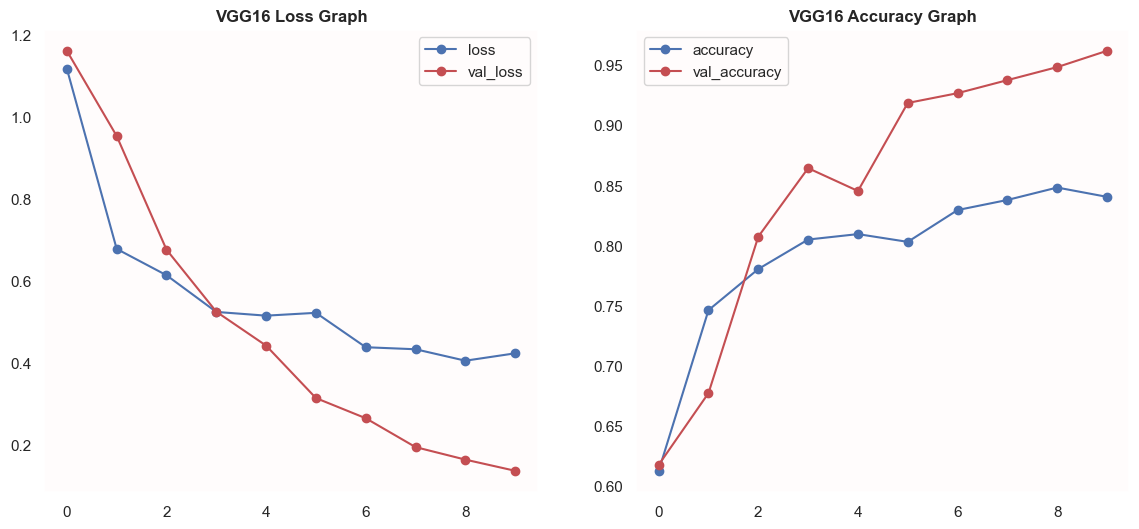

In [91]:
fig,ax = plt.subplots(1,2,figsize=(14,6))

ax[0].plot(history1.history['loss'],label='loss',marker='o', color='b')
ax[0].plot(history1.history['val_loss'],label='val_loss',marker='o', color='r')
ax[0].set_title('VGG16 Loss Graph',fontweight='bold')
ax[0].legend()
ax[0].grid(False)

ax[1].plot(history1.history['accuracy'],label='accuracy',marker='o', color='b')
ax[1].plot(history1.history['val_accuracy'],label='val_accuracy',marker='o', color='r')
ax[1].set_title('VGG16 Accuracy Graph',fontweight='bold')
ax[1].legend()
ax[1].grid(False)

plt.show()

In [127]:
model1.save('C:/Users/Lenovo/CLDD/thesis Code/Model/cotton_leaf_disease_using_vgg16.h5')

**INCEPTION_V3**

In [99]:
inception = InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# **TRAINING INCEPTION_V3 MODEL**

In [113]:
%%time

# Freezing base model
for layer in inception.layers:
    layer.trainable = False

# Adding custom layers on top of model
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

# Predictions
predictions2 = Dense(5, activation='softmax')(x)

# Building Model
model2 = Model(inputs=inception.input, outputs=predictions2)

CPU times: total: 156 ms
Wall time: 141 ms


# **COMPILING INCEPTION_V3 MODEL**

In [116]:
%%time

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
callbacks = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1,
                            mode='max', restore_best_weights=True)

CPU times: total: 15.6 ms
Wall time: 17 ms


# **FITTING INCEPTION_V3 MODEL**

In [119]:
history2 = model2.fit(train_generator, validation_data=validation_generator, epochs=20, callbacks=[callbacks], verbose=1, class_weight=weight_dict)

Epoch 1/20
49/49 [==============================] - 116s 2s/step - loss: 1.0179 - accuracy: 0.6703 - val_loss: 0.5612 - val_accuracy: 0.7642
Epoch 2/20
49/49 [==============================] - 109s 2s/step - loss: 0.5378 - accuracy: 0.8116 - val_loss: 0.2864 - val_accuracy: 0.8835
Epoch 3/20
49/49 [==============================] - 109s 2s/step - loss: 0.4383 - accuracy: 0.8445 - val_loss: 0.1369 - val_accuracy: 0.9675
Epoch 4/20
49/49 [==============================] - 106s 2s/step - loss: 0.4146 - accuracy: 0.8523 - val_loss: 0.1470 - val_accuracy: 0.9485
Epoch 5/20
49/49 [==============================] - 106s 2s/step - loss: 0.3401 - accuracy: 0.8684 - val_loss: 0.1263 - val_accuracy: 0.9566
Epoch 6/20
49/49 [==============================] - 106s 2s/step - loss: 0.3004 - accuracy: 0.8903 - val_loss: 0.0818 - val_accuracy: 0.9729
Epoch 7/20
49/49 [==============================] - 106s 2s/step - loss: 0.2481 - accuracy: 0.9058 - val_loss: 0.1078 - val_accuracy: 0.9702
Epoch 8/20
49

# **EVALUATING INCEPTION_V3 MODEL**

In [123]:
# Evaluate on the Training set
loss, train_acc = model2.evaluate(train_generator)
print(f'\033[1m Training Accuracy: {train_acc * 100:.2f}%\033[0m')

# Evaluate on the validation set
val_loss, val_acc = model2.evaluate(validation_generator)
print(f'\033[1mValidation Accuracy: {val_acc * 100:.2f}%\033[0m')

# Evaluate on the test set
test_loss, test_acc = model2.evaluate(test_generator)
print(f'\033[1mTest Accuracy: {test_acc * 100:.2f}%\033[0m')

49/49 [==============================] - 83s 2s/step - loss: 0.0797 - accuracy: 0.9710
 Training Accuracy: 97.10%
12/12 [==============================] - 19s 2s/step - loss: 0.0291 - accuracy: 0.9919
Validation Accuracy: 99.19%
13/13 [==============================] - 21s 2s/step - loss: 0.0897 - accuracy: 0.9702
Test Accuracy: 97.02%


# **PLOTTING INCEPTION_V3 LOSS AND ACCURACY**

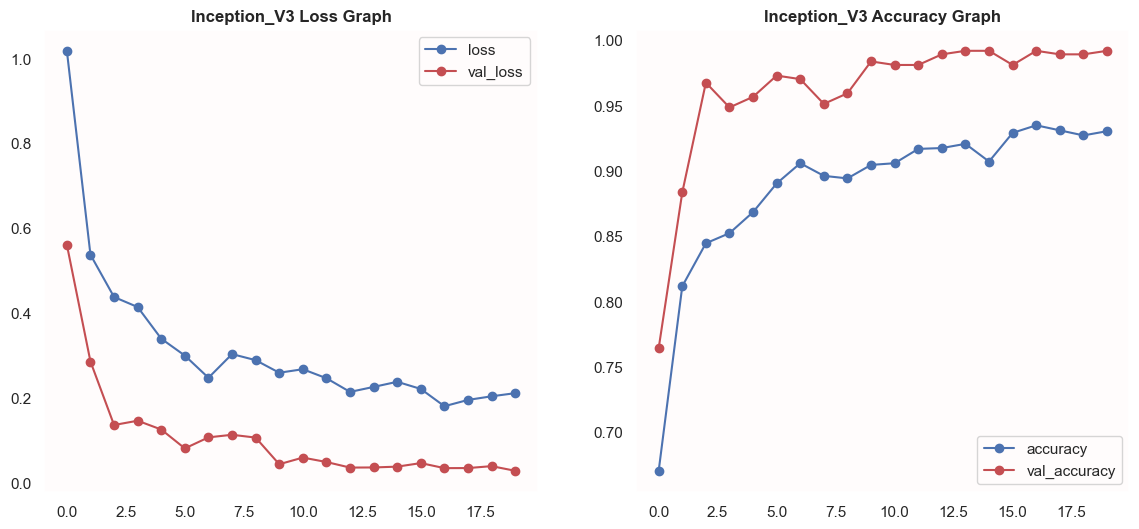

In [125]:
fig,ax = plt.subplots(1,2,figsize=(14,6))

ax[0].plot(history2.history['loss'],label='loss',marker='o', color='b')
ax[0].plot(history2.history['val_loss'],label='val_loss',marker='o', color='r')
ax[0].set_title('Inception_V3 Loss Graph',fontweight='bold')
ax[0].legend()
ax[0].grid(False)

ax[1].plot(history2.history['accuracy'],label='accuracy',marker='o', color='b')
ax[1].plot(history2.history['val_accuracy'],label='val_accuracy',marker='o', color='r')
ax[1].set_title('Inception_V3 Accuracy Graph',fontweight='bold')
ax[1].legend()
ax[1].grid(False)
plt.show()

In [129]:
model2.save('C:/Users/Lenovo/CLDD/thesis Code/Model/cotton_leaf_disease_using_inceptionV3.h5')